## Preliminaries and Dataframe Construction

In [1]:
# Import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
import random

#Import Encounters from Database Query
df = pd.read_pickle("encounters.pkl")

#Formatting
plt.rcParams['font.family'] = 'Times New Roman'  # Set plt shows font to Times New Roman
plt.rcParams['axes.grid'] = True  # Ensure line graphs display on graphs
sns.set_palette(sns.color_palette('Set2')) #set color palette to a nice seaborn style https://seaborn.pydata.org/tutorial/color_palettes.html

## Simulate Multiple Capacity Levels (at 250 Runs)
Extending the approach of Bhavani et al., our model simulates an n/20 (i.e. 5%, 10%...95% capacity, where n = <20>) ventilator shortage by: (1) randomly sampling 20 patients from our dataset, and assigning them to ten pairs (A and B), (2) if n>10, assigning ventilators to both patients in the first n/2 pairs (i.e. A=1, B=1), and if n≤10 assigning no ventilator to both patients in n/2 pairs (i.e. A=0, B=0), (3) ranking the individuals in each remaining pair for priority based on the relevant protocol (i.e. A>B), 4) assigning a ventilator to the highest priority patient in each pair (e.g. A=1, B=0), and 4) repeating this process until all patients in our dataset have been assigned to receive or not receive a ventilator.

NOTE: This strategy avoids over-performance due to large "brackets" of allocation (i.e. allocate 100 beds all at once). Instead, all patients are allocated to pairs and only some pairs have protocol applied depending on capacity (the rest are either deterministictally allocated a bed or sent to die)

In [2]:
##Colorado

df_small_TEST = (df
      .rename(columns={'Survived':'Actual_Survival'})
      .reindex(columns=['EncounterID', 'Age', 'Race', 'Age_Group', 'NY_Score', 'Maryland_Score', 'Colorado_Score', 'Actual_Survival'])
      .assign(Age_Group_N = lambda df_1:
            df_1['Age_Group'].map({'<25': 1, '25-34': 2, '35-44': 3, '45-54': 4, '55-64': 5, '65-74': 6, '75-84': 7, '>85': 8}).astype(int)
      )
)

#MC for different degrees of scarcity with NY Protocol
#beds = 1
patients = 20 #sets denominator of capacity (i.e. number of patients per bed) across all simulations
sample_size = 3700 #size of each sample (i.e. number of patients drawn from dataset) per MC simulation run
runs = 250 #number of MC simulations per capacity level

MC_Colorado_All = pd.DataFrame()

for b in range(1,21): #iterate over bed numbers from 1 - 20 (to set numerator of capacity - with "patients" as denominator)
      beds = b #set number of free beds for this batch of runs
      for i in range(runs): #iterate over each run
            sample = (df_small_TEST
            .sample(n=sample_size, replace=False) #randomly shuffle dataframe w/o replacement
            .assign(Protocol = 5,
                  Beds = beds,
                  Run = i+1,
                  Capacity = (beds/patients), 
                  Allocated = 0, 
                  Survived = 0, 
                  Bracket = lambda df_0:
                        np.arange(len(df_0)) // patients + 1, 
                  )
            .assign(Decision_Pair = lambda df_1: #assign a number to each pair in a bracket.
                        df_1.groupby(['Bracket'])['Allocated'].cumcount() // 2+1
                  )
            .assign(Rank=lambda df_2: df_2
                  #     .groupby(['Bracket', 'Decision_Pair'])['EncounterID'].rank(method="first") # LOTTERY (1)
                  #     .groupby(['Bracket', 'Decision_Pair'])['NY_Score'].rank(method="first") #NY SOFA (2)
                  #     .groupby(['Bracket', 'Decision_Pair'])['Age_Group_N'].rank(method="first") # AGE-GROUP (3)
                  #     .sort_values('Age') 
                  #     .groupby(['Bracket', 'Decision_Pair'])['Maryland_Score'].rank(method="first") #Maryland (4)
                       .groupby(['Bracket', 'Decision_Pair'])['Colorado_Score'].rank(method="first") #COLORADO (5)
                  )
            .assign(Rank = lambda df_3: df_3['Rank'].mask(df_3['Decision_Pair'] <= (beds - patients//2), 1)
                        if beds > (patients // 2) #IF beds is greater than 10, then assign first priority to everyone whose decision-pair is less than beds-10
                        else df_3['Rank'].mask(df_3['Decision_Pair'] > beds, 2) #if beds is less than or equal to 10, then assign last priority to all whose decision-pair is greater than the # of beds
                  )
            .assign(Allocated=lambda df_3: df_3['Allocated'].mask(df_3['Rank'] <= 1, 1))
            .assign(Survived = lambda df_3: df_3['Survived'].mask(df_3['Allocated'] == 1, df_3['Actual_Survival']))
            .drop(['Age_Group_N', 'Beds'], axis=1)
            .reindex(columns=['Protocol', 'Capacity', 'Run', 'EncounterID', 'Allocated', 'Survived'])
            )
            MC_Colorado_All = pd.concat([MC_Colorado_All, sample])
MC_Colorado_All.to_csv('MC_Colorado_All.csv', index=False)

In [2]:
##Maryland

df_small_TEST = (df
      .rename(columns={'Survived':'Actual_Survival'})
      .reindex(columns=['EncounterID', 'Age', 'Race', 'Age_Group', 'NY_Score', 'Maryland_Score', 'Colorado_Score', 'Actual_Survival'])
      .assign(Age_Group_N = lambda df_1:
            df_1['Age_Group'].map({'<25': 1, '25-34': 2, '35-44': 3, '45-54': 4, '55-64': 5, '65-74': 6, '75-84': 7, '>85': 8}).astype(int),
            Maryland_Age = lambda df_1:
                  pd.cut(df_1['Age'], [0, 50, 70, 85, np.inf], labels=[1, 2, 3, 4])#.astype(int)
      )
)

#MC for different degrees of scarcity with NY Protocol
#beds = 1
patients = 20 #sets denominator of capacity (i.e. number of patients per bed) across all simulations
sample_size = 3700 #size of each sample (i.e. number of patients drawn from dataset) per MC simulation run
runs = 250 #number of MC simulations per capacity level

MC_Maryland_All = pd.DataFrame()

for b in range(1,21): #iterate over bed numbers from 1 - 20 (to set numerator of capacity - with "patients" as denominator)
      beds = b #set number of free beds for this batch of runs
      for i in range(runs): #iterate over each run
            sample = (df_small_TEST
            .sample(n=sample_size, replace=False) #randomly shuffle dataframe w/o replacement
            .assign(Protocol = 4,
                  Beds = beds,
                  Run = i+1,
                  Capacity = (beds/patients), 
                  Allocated = 0, 
                  Survived = 0, 
                  Bracket = lambda df_0:
                        np.arange(len(df_0)) // patients + 1, 
                  )
            .assign(Decision_Pair = lambda df_1: #assign a number to each pair in a bracket.
                        df_1.groupby(['Bracket'])['Allocated'].cumcount() // 2+1
                  )
            .assign(Rank=lambda df_2: df_2
                  #     .groupby(['Bracket', 'Decision_Pair'])['EncounterID'].rank(method="first") # LOTTERY (1)
                  #     .groupby(['Bracket', 'Decision_Pair'])['NY_Score'].rank(method="first") #NY SOFA (2)
                  #     .groupby(['Bracket', 'Decision_Pair'])['Age_Group_N'].rank(method="first") # AGE-GROUP (3)
                  #     .sort_values('Maryland_Age') 
                       .groupby(['Bracket', 'Decision_Pair'])['Maryland_Score'].rank(method="first") #Maryland (4)
                  #     .groupby(['Bracket', 'Decision_Pair'])['Colorado_Score'].rank(method="first") #COLORADO (5)
                  )
            .assign(Rank = lambda df_3: df_3['Rank'].mask(df_3['Decision_Pair'] <= (beds - patients//2), 1)
                        if beds > (patients // 2) #IF beds is greater than 10, then assign first priority to everyone whose decision-pair is less than beds-10
                        else df_3['Rank'].mask(df_3['Decision_Pair'] > beds, 2) #if beds is less than or equal to 10, then assign last priority to all whose decision-pair is greater than the # of beds
                  )
            .assign(Allocated=lambda df_3: df_3['Allocated'].mask(df_3['Rank'] <= 1, 1))
            .assign(Survived = lambda df_3: df_3['Survived'].mask(df_3['Allocated'] == 1, df_3['Actual_Survival']))
            .reindex(columns=['Protocol', 'Capacity', 'Run', 'EncounterID', 'Allocated', 'Survived'])
            )
            MC_Maryland_All = pd.concat([MC_Maryland_All, sample])
MC_Maryland_All.to_csv('MC_Maryland_All.csv', index=False)

In [ ]:
##Age-Group

df_small_TEST = (df
      .rename(columns={'Survived':'Actual_Survival'})
      .reindex(columns=['EncounterID', 'Age', 'Race', 'Age_Group', 'NY_Score', 'Maryland_Score', 'Colorado_Score', 'Actual_Survival'])
      .assign(Age_Group_N = lambda df_1:
            df_1['Age_Group'].map({'<25': 1, '25-34': 2, '35-44': 3, '45-54': 4, '55-64': 5, '65-74': 6, '75-84': 7, '>85': 8}).astype(int)
      )
)

#MC for different degrees of scarcity with NY Protocol
#beds = 1
patients = 20 #sets denominator of capacity (i.e. number of patients per bed) across all simulations
sample_size = 3700 #size of each sample (i.e. number of patients drawn from dataset) per MC simulation run
runs = 250 #number of MC simulations per capacity level

MC_Age_All = pd.DataFrame()

for b in range(1,21): #iterate over bed numbers from 1 - 20 (to set numerator of capacity - with "patients" as denominator)
      beds = b #set number of free beds for this batch of runs
      for i in range(runs): #iterate over each run
            sample = (df_small_TEST
            .sample(n=sample_size, replace=False) #randomly shuffle dataframe w/o replacement
            .assign(Protocol = 3,
                  Beds = beds,
                  Run = i+1,
                  Capacity = (beds/patients), 
                  Allocated = 0, 
                  Survived = 0, 
                  Bracket = lambda df_0:
                        np.arange(len(df_0)) // patients + 1, 
                  )
            .assign(Decision_Pair = lambda df_1: #assign a number to each pair in a bracket.
                        df_1.groupby(['Bracket'])['Allocated'].cumcount() // 2+1
                  )
            .assign(Rank=lambda df_2: df_2
                  #     .groupby(['Bracket', 'Decision_Pair'])['EncounterID'].rank(method="first") # LOTTERY (1)
                  #     .groupby(['Bracket', 'Decision_Pair'])['NY_Score'].rank(method="first") #NY SOFA (2)
                       .groupby(['Bracket', 'Decision_Pair'])['Age_Group_N'].rank(method="first") # AGE-GROUP (3)
                  #     .sort_values('Age') 
                  #     .groupby(['Bracket', 'Decision_Pair'])['Maryland_Score'].rank(method="first") #Maryland (4)
                  #     .groupby(['Bracket', 'Decision_Pair'])['Colorado_Score'].rank(method="first") #COLORADO (5)
                  )
            .assign(Rank = lambda df_3: df_3['Rank'].mask(df_3['Decision_Pair'] <= (beds - patients//2), 1)
                        if beds > (patients // 2) #IF beds is greater than 10, then assign first priority to everyone whose decision-pair is less than beds-10
                        else df_3['Rank'].mask(df_3['Decision_Pair'] > beds, 2) #if beds is less than or equal to 10, then assign last priority to all whose decision-pair is greater than the # of beds
                  )
            .assign(Allocated=lambda df_3: df_3['Allocated'].mask(df_3['Rank'] <= 1, 1))
            .assign(Survived = lambda df_3: df_3['Survived'].mask(df_3['Allocated'] == 1, df_3['Actual_Survival']))
            .reindex(columns=['Protocol', 'Capacity', 'Run', 'EncounterID', 'Allocated', 'Survived'])
            )
            MC_Age_All = pd.concat([MC_Age_All, sample])
MC_Age_All.to_csv('MC_Age_All.csv', index=False)

In [ ]:
##NY SOFA

df_small_TEST = (df
      .rename(columns={'Survived':'Actual_Survival'})
      .reindex(columns=['EncounterID', 'Age', 'Race', 'Age_Group', 'NY_Score', 'Maryland_Score', 'Colorado_Score', 'Actual_Survival'])
      .assign(Age_Group_N = lambda df_1:
            df_1['Age_Group'].map({'<25': 1, '25-34': 2, '35-44': 3, '45-54': 4, '55-64': 5, '65-74': 6, '75-84': 7, '>85': 8}).astype(int)
      )
)

#MC for different degrees of scarcity with NY Protocol
#beds = 1
patients = 20 #sets denominator of capacity (i.e. number of patients per bed) across all simulations
sample_size = 3700 #size of each sample (i.e. number of patients drawn from dataset) per MC simulation run
runs = 250 #number of MC simulations per capacity level

MC_NY_All = pd.DataFrame()

for b in range(1,21): #iterate over bed numbers from 1 - 20 (to set numerator of capacity - with "patients" as denominator)
      beds = b #set number of free beds for this batch of runs
      for i in range(runs): #iterate over each run
            sample = (df_small_TEST
            .sample(n=sample_size, replace=False) #randomly shuffle dataframe w/o replacement
            .assign(Protocol = 2,
                  Beds = beds,
                  Run = i+1,
                  Capacity = (beds/patients), 
                  Allocated = 0, 
                  Survived = 0, 
                  Bracket = lambda df_0:
                        np.arange(len(df_0)) // patients + 1, 
                  )
            .assign(Decision_Pair = lambda df_1: #assign a number to each pair in a bracket.
                        df_1.groupby(['Bracket'])['Allocated'].cumcount() // 2+1
                  )
            .assign(Rank=lambda df_2: df_2
                  #     .groupby(['Bracket', 'Decision_Pair'])['EncounterID'].rank(method="first") # LOTTERY (1)
                       .groupby(['Bracket', 'Decision_Pair'])['NY_Score'].rank(method="first") #NY SOFA (2)
                  #     .groupby(['Bracket', 'Decision_Pair'])['Age_Group_N'].rank(method="first") # AGE-GROUP (3)
                  #     .sort_values('Age') 
                  #     .groupby(['Bracket', 'Decision_Pair'])['Maryland_Score'].rank(method="first") #Maryland (4)
                  #     .groupby(['Bracket', 'Decision_Pair'])['Colorado_Score'].rank(method="first") #COLORADO (5)
                  )
            .assign(Rank = lambda df_3: df_3['Rank'].mask(df_3['Decision_Pair'] <= (beds - patients//2), 1)
                        if beds > (patients // 2) #IF beds is greater than 10, then assign first priority to everyone whose decision-pair is less than beds-10
                        else df_3['Rank'].mask(df_3['Decision_Pair'] > beds, 2) #if beds is less than or equal to 10, then assign last priority to all whose decision-pair is greater than the # of beds
                  )
            .assign(Allocated=lambda df_3: df_3['Allocated'].mask(df_3['Rank'] <= 1, 1))
            .assign(Survived = lambda df_3: df_3['Survived'].mask(df_3['Allocated'] == 1, df_3['Actual_Survival']))
            .reindex(columns=['Protocol', 'Capacity', 'Run', 'EncounterID', 'Allocated', 'Survived'])
            )
            MC_NY_All = pd.concat([MC_NY_All, sample])
MC_NY_All.to_csv('MC_NY_All.csv', index=False)

In [ ]:
##Lottery

df_small_TEST = (df
      .rename(columns={'Survived':'Actual_Survival'})
      .reindex(columns=['EncounterID', 'Age', 'Race', 'Age_Group', 'NY_Score', 'Maryland_Score', 'Colorado_Score', 'Actual_Survival'])
      .assign(Age_Group_N = lambda df_1:
            df_1['Age_Group'].map({'<25': 1, '25-34': 2, '35-44': 3, '45-54': 4, '55-64': 5, '65-74': 6, '75-84': 7, '>85': 8}).astype(int)
      )
)

#MC for different degrees of scarcity with NY Protocol
#beds = 1
patients = 20 #sets denominator of capacity (i.e. number of patients per bed) across all simulations
sample_size = 3700 #size of each sample (i.e. number of patients drawn from dataset) per MC simulation run
runs = 250 #number of MC simulations per capacity level

MC_Lott_All = pd.DataFrame()

for b in range(1,21): #iterate over bed numbers from 1 - 20 (to set numerator of capacity - with "patients" as denominator)
      beds = b #set number of free beds for this batch of runs
      for i in range(runs): #iterate over each run
            sample = (df_small_TEST
            .sample(n=sample_size, replace=False) #randomly shuffle dataframe w/o replacement
            .assign(Protocol = 1,
                  Beds = beds,
                  Run = i+1,
                  Capacity = (beds/patients), 
                  Allocated = 0, 
                  Survived = 0, 
                  Bracket = lambda df_0:
                        np.arange(len(df_0)) // patients + 1,
                  Random = np.random.randint(0,5000,size=3700), 
                  )
            .assign(Decision_Pair = lambda df_1: #assign a number to each pair in a bracket.
                        df_1.groupby(['Bracket'])['Allocated'].cumcount() // 2+1
                  )
            .assign(Rank=lambda df_2: df_2
                       .groupby(['Bracket', 'Decision_Pair'])['Random'].rank(method="first") # LOTTERY (1)
                  #     .groupby(['Bracket', 'Decision_Pair'])['NY_Score'].rank(method="first") #NY SOFA (2)
                  #     .groupby(['Bracket', 'Decision_Pair'])['Age_Group_N'].rank(method="first") # AGE-GROUP (3)
                  #     .sort_values('Age') 
                  #     .groupby(['Bracket', 'Decision_Pair'])['Maryland_Score'].rank(method="first") #Maryland (4)
                  #     .groupby(['Bracket', 'Decision_Pair'])['Colorado_Score'].rank(method="first") #COLORADO (5)
                  )
            .assign(Rank = lambda df_3: df_3['Rank'].mask(df_3['Decision_Pair'] <= (beds - patients//2), 1)
                        if beds > (patients // 2) #IF beds is greater than 10, then assign first priority to everyone whose decision-pair is less than beds-10
                        else df_3['Rank'].mask(df_3['Decision_Pair'] > beds, 2) #if beds is less than or equal to 10, then assign last priority to all whose decision-pair is greater than the # of beds
                  )
            .assign(Allocated=lambda df_3: df_3['Allocated'].mask(df_3['Rank'] <= 1, 1))
            .assign(Survived = lambda df_3: df_3['Survived'].mask(df_3['Allocated'] == 1, df_3['Actual_Survival']))
            .reindex(columns=['Protocol', 'Capacity', 'Run', 'EncounterID', 'Allocated', 'Survived'])
            )
            MC_Lott_All = pd.concat([MC_Lott_All, sample])
MC_Lott_All.to_csv('MC_Lott_All.csv', index=False)

In [ ]:
##Pure SOFA

df_small_TEST = (df
      .rename(columns={'Survived':'Actual_Survival'})
      .reindex(columns=['EncounterID', 'Age', 'Race', 'Age_Group', 'InitialSOFA', 'Maryland_Score', 'Colorado_Score', 'Actual_Survival'])
      .assign(Age_Group_N = lambda df_1:
            df_1['Age_Group'].map({'<25': 1, '25-34': 2, '35-44': 3, '45-54': 4, '55-64': 5, '65-74': 6, '75-84': 7, '>85': 8}).astype(int)
      )
)

#MC for different degrees of scarcity with NY Protocol
#beds = 1
patients = 20 #sets denominator of capacity (i.e. number of patients per bed) across all simulations
sample_size = 3700 #size of each sample (i.e. number of patients drawn from dataset) per MC simulation run
runs = 250 #number of MC simulations per capacity level

MC_sofa_All = pd.DataFrame()

for b in range(1,21): #iterate over bed numbers from 1 - 20 (to set numerator of capacity - with "patients" as denominator)
      beds = b #set number of free beds for this batch of runs
      for i in range(runs): #iterate over each run
            sample = (df_small_TEST
            .sample(n=sample_size, replace=False) #randomly shuffle dataframe w/o replacement
            .assign(Protocol = 6,
                  Beds = beds,
                  Run = i+1,
                  Capacity = (beds/patients), 
                  Allocated = 0, 
                  Survived = 0, 
                  Bracket = lambda df_0:
                        np.arange(len(df_0)) // patients + 1, 
                  )
            .assign(Decision_Pair = lambda df_1: #assign a number to each pair in a bracket.
                        df_1.groupby(['Bracket'])['Allocated'].cumcount() // 2+1
                  )
            .assign(Rank=lambda df_2: df_2
                       .groupby(['Bracket', 'Decision_Pair'])['InitialSOFA'].rank(method="first") # Pure SOFA (6)
                  #     .groupby(['Bracket', 'Decision_Pair'])['NY_Score'].rank(method="first") #NY SOFA (2)
                  #     .groupby(['Bracket', 'Decision_Pair'])['Age_Group_N'].rank(method="first") # AGE-GROUP (3)
                  #     .sort_values('Age') 
                  #     .groupby(['Bracket', 'Decision_Pair'])['Maryland_Score'].rank(method="first") #Maryland (4)
                  #     .groupby(['Bracket', 'Decision_Pair'])['Colorado_Score'].rank(method="first") #COLORADO (5)
                  )
            .assign(Rank = lambda df_3: df_3['Rank'].mask(df_3['Decision_Pair'] <= (beds - patients//2), 1)
                        if beds > (patients // 2) #IF beds is greater than 10, then assign first priority to everyone whose decision-pair is less than beds-10
                        else df_3['Rank'].mask(df_3['Decision_Pair'] > beds, 2) #if beds is less than or equal to 10, then assign last priority to all whose decision-pair is greater than the # of beds
                  )
            .assign(Allocated=lambda df_3: df_3['Allocated'].mask(df_3['Rank'] <= 1, 1))
            .assign(Survived = lambda df_3: df_3['Survived'].mask(df_3['Allocated'] == 1, df_3['Actual_Survival']))
            .reindex(columns=['Protocol', 'Capacity', 'Run', 'EncounterID', 'Allocated', 'Survived'])
            )
            MC_sofa_All = pd.concat([MC_sofa_All, sample])
MC_sofa_All.to_csv('MC_sofa_All.csv', index=False)

### NOT UTILISED - Alternate Strategy fof Simulating Monte Carlo for Capacity Levels
The stratgey described below allocates all beds simultaneously in blocks of 100 patients, with different capacities modelled by decreasing the number of beds available out of 100. This *prima facie* intuitive approach to modelling capacity constraints betwene 0.01 and 0.99, was the first strategy we tried to simulate capacity constraints. Upon reflection, however, we noted that this overestimates the efficiency of some protocols because they are able to make use of fine-grained distinctions between the survival likelihood of patients when they are alllocated in sets of 100. Of course, most allocation deicsions will be made with much smaller sets of patients (i.e. in pairs). We illustrate the way in which this over-estimate of protocol efficiacy can occur by simulating the implementation of the NY SOFA protocol a 50% capacity constraint, using a 1/2, 2/4, 3/6, 4/8, 5/10, 10/20, 25/50 and 50/100 bed to patient ratio.

In [ ]:
#Age, Different Capacities
df_large_colorado = (df
      .rename(columns={'Survived':'Actual_Survival'})
      .reindex(columns=['Protocol', 'EncounterID', 'Colorado_Score', 'Actual_Survival'])
      .assign(Age_Group_N = lambda df_1:
            df_1['Age_Group'].map({'<25': 1, '25-34': 2, '35-44': 3, '45-54': 4, '55-64': 5, '65-74': 6, '75-84': 7, '>85': 8}).astype(int)
      )
)
#MC for different degrees of scarcity with NY Protocol
patients = 100 #patients fixed level across simulations
decisions = 3700 #number of monte carlo samples per MC simulation
runs = 10 #number of MC simulations per capacity level

MC_Capacity_Test = pd.DataFrame()
for b in range(100): #iterate over capacity levels from 0.01 - 0.99 (i.e. beds/100)
      beds = b #set number of free beds for this batch of runs
      for i in range(runs): #iterate over each run
            sample = (df_large_colorado
            .sample(n=decisions, replace=False) #randomly shuffle dataframe w/o replacement
            .assign(Run = i+1, 
                  Capacity = (beds/patients), 
                  Allocated=0, 
                  Survived = 0, 
                  )
            .assign(Decision = lambda df_1:
                        np.arange(len(df_1)) // patients + 1, 
                  )
            .assign(Rank=lambda df_2: 
                  #     df_2.groupby(['Decision'])['NY_Score'].rank(method="first") #NY SOFA 
                  #     df_2.groupby(['Decision'])['Age_Group_N'].rank(method="first") # AGE
                       df_2.groupby(['Decision'])['EncounterID'].rank(method="first") # LOTTERY
                  )
            .assign(Allocated=lambda df_3: 
                        df_3['Allocated'].mask(df_3['Rank'] <= beds, 1),
                  Survived = lambda df_3: 
                        df_3['Survived'].mask(df_3['Rank'] <= beds, df_3['Actual_Survival'])
                  )
            .drop(['Age_Group_N'], axis=1)
            .groupby(['Decision', 'Race'], as_index=False).sum()
            )
            MC_Capacity_Test = pd.concat([MC_Capacity_Test, sample])

MC_Capacity_Test.to_csv('MC_Capacity_test.csv', index=False)

### Monte Carlo Robustness Testing
In conversation, Will Parker (https://med-faculty.bsd.uchicago.edu/Default/Details/13626) noted that efficiency of allocation may be artificially increased (for non Lottery) if number of beds available increases for each % of scarcity. We test sensitivity of the simulation to size of allocation bracket (bed/patients).\
#1 - 1/2, #2 - 2/4, #3 - 3/6, #4 - 4/8, #5 - 5/10, #6 - 10/20, #7 - 20/40, #8 - 30/60, #9 - 40/80, #8 - 50/100

In [7]:
#Age, Different Capacities
df_small_robustness = (df
      .rename(columns={'Survived':'Actual_Survival'})
#      .reindex(columns=['EncounterID', 'Race', 'Age_Group', 'NY_Score', 'Actual_Survival'])
      .reindex(columns=['EncounterID', 'Age', 'Race', 'Age_Group', 'NY_Score', 'Maryland_Score', 'Colorado_Score', 'Actual_Survival'])
      .assign(Age_Group_N = lambda df_1:
            df_1['Age_Group'].map({'<25': 1, '25-34': 2, '35-44': 3, '45-54': 4, '55-64': 5, '65-74': 6, '75-84': 7, '>85': 8}).astype(int)
      )
)
#Robustness testing for a 50% scarcity with NY Protocol
#patients = 100 #patients fixed level across simulations
decisions = 3600 #number of monte carlo samples per MC simulation
runs = 100 #number of MC simulations per capacity level

MC_Capacity_Robustness_Test = pd.DataFrame()
for b in [1,2,3,4,5,10, 20, 30, 40, 50, 100, 200]:#range(1,21): #iterate over bed numbers from 1 - 20 (where patients = 2*beds to sim 50% scarcity)
      beds = b #set number of free beds for this batch of runs
      for i in range(runs): #iterate over each run
            patients = beds*2
            sample = (df_small_robustness
            .sample(n=decisions, replace=False) #randomly shuffle dataframe w/o replacement
            .assign(Protocol = 'NY_SOFA',
                  Beds = beds,
                  Run = i+1,
                  Capacity = (beds/patients), 
                  Allocated = 0, 
                  Survived = 0, 
                  )
            .assign(Decision = lambda df_1:
                        np.arange(len(df_1)) // patients + 1, 
                  )
            .assign(Rank=lambda df_2: df_2
                       .groupby(['Decision'])['NY_Score'].rank(method="first") #NY SOFA 
                  #     .groupby(['Decision'])['Age_Group_N'].rank(method="first") # AGE
                  #     .groupby(['Decision'])['EncounterID'].rank(method="first") # LOTTERY
                  #     .sort_values('Age')
                  #     .groupby(['Decision'])['Maryland_Score'].rank(method="first")
                  #     .groupby(['Decision'])['Colorado_Score'].rank(method="first")
                  )
            .assign(Allocated=lambda df_3: 
                        df_3['Allocated'].mask(df_3['Rank'] <= beds, 1),
                  Survived = lambda df_3: 
                        df_3['Survived'].mask(df_3['Rank'] <= beds, df_3['Actual_Survival'])
                  )
            .drop(['Age_Group_N'], axis=1)
            #.groupby(['Decision', 'Race', 'Age_Group'], as_index=False).sum(numeric_only=True)
            )
            MC_Capacity_Robustness_Test = pd.concat([MC_Capacity_Robustness_Test, sample])

for b in [1,2,3,4,5,10, 20, 30, 40, 50, 100, 200]:#range(1,21): #iterate over bed numbers from 1 - 20 (where patients = 2*beds to sim 50% scarcity)
      beds = b #set number of free beds for this batch of runs
      for i in range(runs): #iterate over each run
            patients = beds*2
            sample = (df_small_robustness
            .sample(n=decisions, replace=False) #randomly shuffle dataframe w/o replacement
            .assign(Protocol = 'Age',
                  Beds = beds,
                  Run = i+1,
                  Capacity = (beds/patients), 
                  Allocated = 0, 
                  Survived = 0, 
                  )
            .assign(Decision = lambda df_1:
                        np.arange(len(df_1)) // patients + 1, 
                  )
            .assign(Rank=lambda df_2: df_2
                  #     .groupby(['Decision'])['NY_Score'].rank(method="first") #NY SOFA 
                       .groupby(['Decision'])['Age_Group_N'].rank(method="first") # AGE
                  #     .groupby(['Decision'])['EncounterID'].rank(method="first") # LOTTERY
                  #     .sort_values('Age')
                  #     .groupby(['Decision'])['Maryland_Score'].rank(method="first")
                  #     .groupby(['Decision'])['Colorado_Score'].rank(method="first")
                  )
            .assign(Allocated=lambda df_3: 
                        df_3['Allocated'].mask(df_3['Rank'] <= beds, 1),
                  Survived = lambda df_3: 
                        df_3['Survived'].mask(df_3['Rank'] <= beds, df_3['Actual_Survival'])
                  )
            .drop(['Age_Group_N'], axis=1)
            #.groupby(['Decision', 'Race', 'Age_Group'], as_index=False).sum(numeric_only=True)
            )
            MC_Capacity_Robustness_Test = pd.concat([MC_Capacity_Robustness_Test, sample])

for b in [1,2,3,4,5,10, 20, 30, 40, 50, 100, 200]:#range(1,21): #iterate over bed numbers from 1 - 20 (where patients = 2*beds to sim 50% scarcity)
      beds = b #set number of free beds for this batch of runs
      for i in range(runs): #iterate over each run
            patients = beds*2
            sample = (df_small_robustness
            .sample(n=decisions, replace=False) #randomly shuffle dataframe w/o replacement
            .assign(Protocol = 'Lottery',
                  Beds = beds,
                  Run = i+1,
                  Capacity = (beds/patients), 
                  Allocated = 0, 
                  Survived = 0, 
                  )
            .assign(Decision = lambda df_1:
                        np.arange(len(df_1)) // patients + 1, 
                  )
            .assign(Rank=lambda df_2: df_2
                  #     .groupby(['Decision'])['NY_Score'].rank(method="first") #NY SOFA 
                  #     .groupby(['Decision'])['Age_Group_N'].rank(method="first") # AGE
                       .groupby(['Decision'])['EncounterID'].rank(method="first") # LOTTERY
                  #     .sort_values('Age')
                  #     .groupby(['Decision'])['Maryland_Score'].rank(method="first")
                  #     .groupby(['Decision'])['Colorado_Score'].rank(method="first")
                  )
            .assign(Allocated=lambda df_3: 
                        df_3['Allocated'].mask(df_3['Rank'] <= beds, 1),
                  Survived = lambda df_3: 
                        df_3['Survived'].mask(df_3['Rank'] <= beds, df_3['Actual_Survival'])
                  )
            .drop(['Age_Group_N'], axis=1)
            #.groupby(['Decision', 'Race', 'Age_Group'], as_index=False).sum(numeric_only=True)
            )
            MC_Capacity_Robustness_Test = pd.concat([MC_Capacity_Robustness_Test, sample])

for b in [1,2,3,4,5,10, 20, 30, 40, 50, 100, 200]:#range(1,21): #iterate over bed numbers from 1 - 20 (where patients = 2*beds to sim 50% scarcity)
      beds = b #set number of free beds for this batch of runs
      for i in range(runs): #iterate over each run
            patients = beds*2
            sample = (df_small_robustness
            .sample(n=decisions, replace=False) #randomly shuffle dataframe w/o replacement
            .assign(Protocol = 'Maryland',
                  Beds = beds,
                  Run = i+1,
                  Capacity = (beds/patients), 
                  Allocated = 0, 
                  Survived = 0, 
                  )
            .assign(Decision = lambda df_1:
                        np.arange(len(df_1)) // patients + 1, 
                  )
            .assign(Rank=lambda df_2: df_2
                  #     .groupby(['Decision'])['NY_Score'].rank(method="first") #NY SOFA 
                  #     .groupby(['Decision'])['Age_Group_N'].rank(method="first") # AGE
                  #     .groupby(['Decision'])['EncounterID'].rank(method="first") # LOTTERY
                       .sort_values('Age')
                       .groupby(['Decision'])['Maryland_Score'].rank(method="first")
                  #     .groupby(['Decision'])['Colorado_Score'].rank(method="first")
                  )
            .assign(Allocated=lambda df_3: 
                        df_3['Allocated'].mask(df_3['Rank'] <= beds, 1),
                  Survived = lambda df_3: 
                        df_3['Survived'].mask(df_3['Rank'] <= beds, df_3['Actual_Survival'])
                  )
            .drop(['Age_Group_N'], axis=1)
            #.groupby(['Decision', 'Race', 'Age_Group'], as_index=False).sum(numeric_only=True)
            )
            MC_Capacity_Robustness_Test = pd.concat([MC_Capacity_Robustness_Test, sample])

for b in [1,2,3,4,5,10, 20, 30, 40, 50, 100, 200]:#range(1,21): #iterate over bed numbers from 1 - 20 (where patients = 2*beds to sim 50% scarcity)
      beds = b #set number of free beds for this batch of runs
      for i in range(runs): #iterate over each run
            patients = beds*2
            sample = (df_small_robustness
            .sample(n=decisions, replace=False) #randomly shuffle dataframe w/o replacement
            .assign(Protocol = 'Colorado',
                  Beds = beds,
                  Run = i+1,
                  Capacity = (beds/patients), 
                  Allocated = 0, 
                  Survived = 0, 
                  )
            .assign(Decision = lambda df_1:
                        np.arange(len(df_1)) // patients + 1, 
                  )
            .assign(Rank=lambda df_2: df_2
                  #     .groupby(['Decision'])['NY_Score'].rank(method="first") #NY SOFA 
                  #     .groupby(['Decision'])['Age_Group_N'].rank(method="first") # AGE
                  #     .groupby(['Decision'])['EncounterID'].rank(method="first") # LOTTERY
                  #     .sort_values('Age')
                  #     .groupby(['Decision'])['Maryland_Score'].rank(method="first")
                       .groupby(['Decision'])['Colorado_Score'].rank(method="first")
                  )
            .assign(Allocated=lambda df_3: 
                        df_3['Allocated'].mask(df_3['Rank'] <= beds, 1),
                  Survived = lambda df_3: 
                        df_3['Survived'].mask(df_3['Rank'] <= beds, df_3['Actual_Survival'])
                  )
            .drop(['Age_Group_N'], axis=1)
            #.groupby(['Decision', 'Race', 'Age_Group'], as_index=False).sum(numeric_only=True)
            )
            MC_Capacity_Robustness_Test = pd.concat([MC_Capacity_Robustness_Test, sample])

MC_Capacity_Robustness_Test.to_csv('MC_Capacity_Robustness_test.csv', index=False)

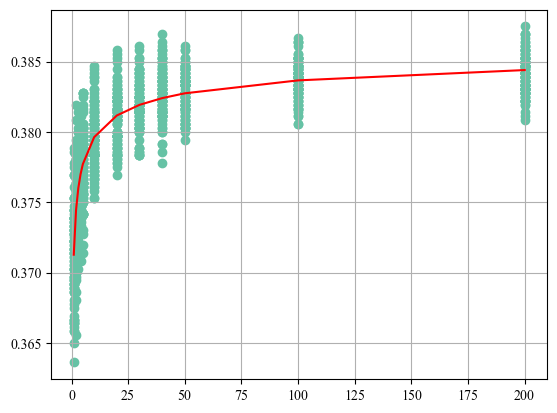

In [12]:
from scipy.optimize import curve_fit

MC_cap_robust = (pd.read_csv('MC_Capacity_Robustness_test.csv')
    .groupby(['Protocol','Beds', 'Run'], as_index=False)['Survived']
    .agg(['sum', 'count'])
    .reset_index()
    .assign(S_rate=lambda df_:df_['sum']/df_['count'])
)


print(MC_cap_robust
    .groupby(['Protocol', 'Beds', 'Run'], as_index=False)['Survived'].agg(['sum', 'count'])
    .assign(S_rate=lambda df_:df_['sum']/df_['count'])
    .groupby(['Protocol', 'Beds'], as_index=False)['S_rate'].agg(['mean', 'var','sem'])
    )

MC_cap_robust = MC_cap_robust[MC_cap_robust.Protocol == 'Lottery']

def asymptote_f(x, a, b, n):
    return a * x ** n  / (x ** n + b)

y = MC_cap_robust['S_rate'].astype(float)
x = MC_cap_robust['Beds'].astype(float)

#popt, pcov = curve_fit(f, x, y, p0=[1800., 20., 1.])
popt, pcov = curve_fit(asymptote_f, x, y, p0=[0.405, 0.001, 0.00001])

plt.scatter(x, y)
plt.plot(x, asymptote_f(x, *popt), 'r-')
plt.show()


#for i in range(len(MC_cap_robust['Protocol'])):
#     plt.scatter(x, y[i], label=f"{MC_cap_robust['Protocol'][i]}")
#     plt.plot(x, asymptote_f(x, MC_cap_robust['Protocol'], *popt), 'r-')
# plt.show()

# https://pyquestions.com/fit-multiple-parametric-curves-with-scipy

**PROOF that Utilized stratgey avoids the over=estimation problem**

In [ ]:
##ALTERNATE MC SIM for multiple capacities that avoids the over-performance for high bed counts

df_small_TEST = (df
      .rename(columns={'Survived':'Actual_Survival'})
      .reindex(columns=['EncounterID', 'Age', 'Race', 'Age_Group', 'NY_Score', 'Maryland_Score', 'Colorado_Score', 'Actual_Survival'])
      .assign(Age_Group_N = lambda df_1:
            df_1['Age_Group'].map({'<25': 1, '25-34': 2, '35-44': 3, '45-54': 4, '55-64': 5, '65-74': 6, '75-84': 7, '>85': 8}).astype(int)
      )
)

#MC for different degrees of scarcity with NY Protocol
#beds = 1
patients = 20 #sets denominator of capacity (i.e. number of patients per bed) across all simulations
sample_size = 3700 #size of each sample (i.e. number of patients drawn from dataset) per MC simulation run
runs = 100 #number of MC simulations per capacity level

results_TEST_capacity = pd.DataFrame()

for b in range(1,21): #iterate over bed numbers from 1 - 20 (to set numerator of capacity - with "patients" as denominator)
      beds = b #set number of free beds for this batch of runs
      for i in range(runs): #iterate over each run
            sample = (df_small_TEST
            .sample(n=sample_size, replace=False) #randomly shuffle dataframe w/o replacement
            .assign(Protocol = 'Colorado',
                  Beds = beds,
                  Run = i+1,
                  Capacity = (beds/patients), 
                  Allocated = 0, 
                  Survived = 0, 
                  Bracket = lambda df_0:
                        np.arange(len(df_0)) // patients + 1, 
                  )
            .assign(Decision_Pair = lambda df_1: #assign a number to each pair in a bracket.
                        df_1.groupby(['Bracket'])['Allocated'].cumcount() // 2+1
                  )
### INSERT ALLOCATION BY BRACKET HERE
            .assign(Rank=lambda df_2: df_2
                  #     .groupby(['Bracket', 'Decision_Pair'])['NY_Score'].rank(method="first") #NY SOFA 
                  #     .groupby(['Bracket', 'Decision_Pair'])['Age_Group_N'].rank(method="first") # AGE-GROUP
                       .groupby(['Bracket', 'Decision_Pair'])['EncounterID'].rank(method="first") # LOTTERY
                  #     .sort_values('Age') 
                  #     .groupby(['Bracket', 'Decision_Pair'])['Maryland_Score'].rank(method="first") #Maryland
                  #     .groupby(['Bracket', 'Decision_Pair'])['Colorado_Score'].rank(method="first") #COLORADO
                  )
            .assign(Rank = lambda df_3: df_3['Rank'].mask(df_3['Decision_Pair'] <= (beds - patients//2), 1)
                        if beds > (patients // 2) #IF beds is greater than 10, then assign first priority to everyone whose decision-pair is less than beds-10
                        else df_3['Rank'].mask(df_3['Decision_Pair'] > beds, 2) #if beds is less than or equal to 10, then assign last priority to all whose decision-pair is greater than the # of beds
                  )
            .assign(Allocated=lambda df_3: df_3['Allocated'].mask(df_3['Rank'] <= 1, 1))
            .assign(Survived = lambda df_3: df_3['Survived'].mask(df_3['Allocated'] == 1, df_3['Actual_Survival']))
            #.drop(['Age_Group_N', 'Beds'], axis=1)
            #### MUST EITHER (1) Run without grouping and keep ecnounter numbers = large file (i.e. 4GB per file) OR (2) identify fields necessary for analysis and preserve groupby for each
            #.groupby(['Run', 'Race', 'Age_Group'], as_index=False).sum(numeric_only=True)
            .reindex(columns=['Protocol', 'Capacity', 'Run', 'EncounterID', 'Allocated', 'Survived'])
            )
            results_TEST_capacity = pd.concat([results_TEST_capacity, sample])
results_TEST_capacity.to_csv('MC_TEST_Cap.csv', index=False)

In [ ]:
#Survival rate at different levels of beds/decision for same scarcity (50%)
from scipy.optimize import curve_fit

order = ['Black','Hispanic', 'White']


MC_TEST_robust = (pd.read_csv('MC_TEST_Cap.csv')
    .groupby(['Capacity', 'Run'], as_index=False)['Survived']
    .agg(['sum', 'count'])
    .reset_index()
    .assign(S_rate=lambda df_:df_['sum']/df_['count'])
)

def asymptote_f(x, a, b, n):
    return a * x ** n  / (x ** n + b)

y = MC_TEST_robust['S_rate'].astype(float)
x = MC_TEST_robust['Capacity'].astype(float)

#popt, pcov = curve_fit(f, x, y, p0=[1800., 20., 1.])
popt, pcov = curve_fit(asymptote_f, x, y, p0=[0.405, 0.001, 0.00001])

plt.scatter(x, y)
plt.plot(x, asymptote_f(x, *popt), 'r-')
plt.show()

MC_TEST_robust_results=MC_TEST_robust.groupby(['Capacity']).mean().to_csv("MC_Test_robust_results.csv")